In [3]:
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime, timedelta

# 設置MySQL資料庫連接
db_user = 'root'
db_password = '19970730'
db_host = '127.0.0.1'
db_name = 'sql_stock'

# 創建資料庫連接引擎
engine = create_engine(f'mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}')

# 設置日期範圍
#today = datetime(2024, 5, 25)
today = datetime.now().date()
one_year_ago = today - timedelta(days=720)

# 格式化日期
today_str = today.strftime('%Y%m%d')
one_year_ago_str = one_year_ago.strftime('%Y%m%d')

# 全撈 
one_year_ago_str = '20200101'

# SQL 查詢 加權指數
query_twse = f"""
SELECT *
FROM daily_twse
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 個股
query_stock = f"""
SELECT *
FROM daily_price
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 細產業
query_sub_category = f"""
SELECT *
FROM sub_category
"""

# SQL 查詢 個股
query_insti_inv = f"""
SELECT *
FROM daily_insti_inv
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame
twse_df_raw = pd.read_sql(query_twse, engine)

stock_df_raw = pd.read_sql(query_stock, engine)

insti_inv_raw = pd.read_sql(query_insti_inv, engine)

sub_category_list = pd.read_sql(query_sub_category, engine)

stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])

insti_inv_raw['Date'] = pd.to_datetime(insti_inv_raw['Date'])

ModuleNotFoundError: No module named 'mysql'

In [ ]:
# # 定義函數來查找 tom_open 和 tom_close
# def get_tomorrow_prices(row):
#     stock_id = row['證券代號']
#     search_date = row['Date']
#     today_close = row['收盤價']
    
#     # 查找下一個交易日的數據
#     temp_df_tom = stock_df_raw[(stock_df_raw['證券代號'] == stock_id) & (stock_df_raw['Date'] > search_date)].copy()
#     if not temp_df_tom.empty:
#         tom_open = temp_df_tom['開盤價'].iloc[0]
#         tom_close = temp_df_tom['收盤價'].iloc[0]
#         tom_diff = round(100 * (tom_close - today_close) / today_close , 2) 
#         return pd.Series([tom_open, tom_close, tom_diff])
#     else:
#         return pd.Series([None, None])

# # 使用 apply 添加 tom_open 和 tom_close
# result_df2[['tom_open', 'tom_close','tom_diff']] = result_df2.apply(get_tomorrow_prices, axis=1)

# filtered_df = result_df2[result_df2['tom_diff'] > 0].copy()

# filtered_df

個股條件測試區

In [147]:
stock_df_today = stock_df_raw[(stock_df_raw['Date']>='2023-03-11' ) & (stock_df_raw['Date']<'2023-03-30' ) & (stock_df_raw['證券代號'] == '3231') ]

tt = stock_df_today[(stock_df_today['收盤價']>stock_df_today['5MA']) & 
                    (stock_df_today['5MA']>stock_df_today['10MA']) & 
                    (stock_df_today['10MA']>stock_df_today['60MA']) & 
                    (stock_df_today['60MA']>stock_df_today['240MA']) & 
                    (stock_df_today['成交金額']>1000000000) &
                    (stock_df_today['成交筆數']>10000) & 
                    (stock_df_today['60RS_rank']>75) &
                    (stock_df_today['20RS_rank']>85) ]


temp_df_his = stock_df_raw[(stock_df_raw['證券代號']=='3231') & (stock_df_raw['Date'] <'2023-03-15') & (stock_df_raw['收盤價'] != 0) ].copy()
temp_df_his.loc[:, '60MAV'] = temp_df_his['成交筆數'].rolling(60).mean()

# 季內高低點
temp_df_his.loc[:, 'backtest_dayDAY_min'] = temp_df_his['收盤價'].rolling(60).min()
temp_df_his.loc[:, 'backtest_dayDAY_max'] = temp_df_his['收盤價'].rolling(60).max()
DAYbacktest_day_min = temp_df_his.tail(1)['backtest_dayDAY_min'].iloc[0]
DAYbacktest_day_max = temp_df_his.tail(1)['backtest_dayDAY_max'].iloc[0]

print(temp_df_his['收盤價'].rolling(60).min().tail(1))
print(temp_df_his['收盤價'].rolling(60).max().tail(1))

print(DAYbacktest_day_min)


print(abs(DAYbacktest_day_max - DAYbacktest_day_min) / DAYbacktest_day_min )

backtest_60MAV = temp_df_his.tail(1)['60MAV'].iloc[0]
print(backtest_60MAV)

1358670    27.3
Name: 收盤價, dtype: float64
1358670    33.95
Name: 收盤價, dtype: float64
27.3
0.24358974358974367
6164.466666666666


In [36]:
test_str_date = '2024-01-01'
test_end_date = '2024-03-30'

In [37]:
import warnings
# 計算出場  使用60RS看看
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
day_list = stock_df_raw[(stock_df_raw['Date']>= test_str_date ) & (stock_df_raw['Date'] <= test_end_date )]
day_list = day_list['Date'].unique().tolist()

backtest_day = 60

# 初始化 filter_stock_list 和 stock_id_filter
filter_stock_list = pd.DataFrame(columns=['Date', '證券代號', '證券名稱', '成交股數', '成交筆數', '成交金額', '開盤價', '收盤價', '明天開盤價', '明天收盤價', '明今差'])
stock_id_filter = set()  # 使用集合來存儲 stock_id，查詢效率更高

# 遍歷日期列表
for day in day_list:

    today_str = day.strftime('%Y-%m-%d')
    
    stock_df_today = stock_df_raw[stock_df_raw['Date'] == today_str].copy() 

    # 收盤在季線以上 年線以上 成值 10億 
    today_list = stock_df_today[(stock_df_today['收盤價']>stock_df_today['5MA']) & 
                                (stock_df_today['5MA']>stock_df_today['10MA']) & 
                                (stock_df_today['10MA']>stock_df_today['60MA']) & 
                                (stock_df_today['60MA']>stock_df_today['240MA']) & 
                                (stock_df_today['成交金額']>1000000000) &
                                (stock_df_today['成交筆數']>10000) & 
                                (stock_df_today['60RS_rank']>75) &
                                (stock_df_today['20RS_rank']>85) ]

    # 計算一年內高點
    stock_id_list = today_list['證券代號'].unique().tolist()

    for i in stock_id_list:
        if len(i) == 4 and i not in stock_id_filter:  # 確保是新 stock_id
            today_df = stock_df_today[stock_df_today['證券代號'] == i]
            close = today_df['收盤價'].iloc[0]
            open = today_df['開盤價'].iloc[0]

            if( close < open):
                continue

            volumn = today_df['成交筆數'].iloc[0]

            temp_df_his = stock_df_raw[
                (stock_df_raw['證券代號'] == i) & 
                (stock_df_raw['Date'] < today_str) & 
                (stock_df_raw['收盤價'] != 0)
            ].copy()

            temp_df_fut = stock_df_raw[
                (stock_df_raw['證券代號'] == i) & 
                (stock_df_raw['Date'] > today_str) & 
                (stock_df_raw['收盤價'] != 0)
            ].copy()

            if not temp_df_fut.empty:
                tom_close = temp_df_fut['收盤價'].iloc[0]
                tom_open = temp_df_fut['開盤價'].iloc[0]
                tom_diff = round(100 * (tom_close - close) / close , 2) 
            else :
                tom_close = 0
                tom_open = 0
                tom_diff = 0

            if temp_df_his.empty:  # 避免 temp_df_his 為空時報錯
                continue

            temp_df_his['60MAV'] = temp_df_his['成交筆數'].rolling(60).mean()

            # 計算高低點和均值
            DAYbacktest_day_min = temp_df_his['收盤價'].rolling(backtest_day).min().iloc[-1]
            DAYbacktest_day_max = temp_df_his['收盤價'].rolling(backtest_day).max().iloc[-1]
            backtest_60MAV = temp_df_his['成交筆數'].rolling(backtest_day).mean().iloc[-1]

            temp_df_his = stock_df_raw[
                (stock_df_raw['證券代號'] == i) & 
                (stock_df_raw['Date'] < today_str) & 
                (stock_df_raw['收盤價'] != 0)
            ].copy()


            # 半年前高
            # DAYbacktest_day_long_max = temp_df_his['收盤價'].rolling(backtest_day*2).max().iloc[-1]


            if pd.isna(DAYbacktest_day_min) or pd.isna(DAYbacktest_day_max):  # 檢查是否有 NA
                print(f"DAY240_min = 0 stock_name: {today_df['證券名稱'].iloc[0]} today_str: {today_str} stock_id: {i}")
                continue

            max_min_diff = abs(DAYbacktest_day_max - DAYbacktest_day_min) / DAYbacktest_day_min

            # 符合條件則添加至過濾列表
            if (volumn > backtest_60MAV * 2.5) and (max_min_diff < 0.3):
                stock_id_filter.add(i)  # 加入 stock_id_filter，避免重複處理
                filter_stock_today = stock_df_today[stock_df_today['證券代號'] == i]
                filter_stock_today = filter_stock_today[['Date', '證券代號', '證券名稱', '成交股數', '成交筆數', '成交金額', '開盤價', '收盤價' ]]
                filter_stock_today['明天開盤價'] = tom_open
                filter_stock_today['明天收盤價'] = tom_close
                filter_stock_today['明今差'] = tom_diff

                filter_stock_list = pd.concat([filter_stock_list, filter_stock_today], ignore_index=True)


filter_stock_list['Date'] = pd.to_datetime(filter_stock_list['Date'])


insti_inv_raw_sim = insti_inv_raw[['Date', '證券代號','自營商買賣超股數(自行買賣)']]
result_df = pd.merge(filter_stock_list, insti_inv_raw_sim, on=['Date', '證券代號'], how='inner')
result_df2 = result_df[result_df['自營商買賣超股數(自行買賣)'] > 100000]

# 確保 Date 是 datetime 格式
result_df2['Date'] = pd.to_datetime(result_df2['Date'])
result_df3 = result_df2[['Date','證券代號','自營商買賣超股數(自行買賣)']]
combined_df = pd.merge(result_df3, stock_df_raw, on=['Date', '證券代號'], how='inner')

# [result_df2['明今差']>0]

C:\Users\USER\AppData\Local\Temp\ipykernel_16472\2935935450.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df2['Date'] = pd.to_datetime(result_df2['Date'])


In [38]:
warnings.simplefilter(action='ignore', category=FutureWarning)
# 拿來當日期基準值
stock_2330 = stock_df_raw[stock_df_raw['證券代號'] == '2330']

loss_type = 0
rs_rank_list = list(range(8, 9, 1)) # 77 

total_earn_data = pd.DataFrame(columns=['hold_day','60rs_rank','20rs_rank',
                                        'total_earn_close','total_earn_open','total_earn_mix','total_earn_nonsetloss_close','total_earn_nonsetloss_open' ,
                                        'len',
                                        'earn_close_min','earn_open_min','earn_mix_min','earn_nonsetloss_open_min','earn_nonsetloss_close_min',
                                        'avg_hold_day'])
for j in rs_rank_list:
    
    k = 75 # 60天RS

    earn_date_list = pd.DataFrame(columns=['證券代號','證券名稱','select_day',
                                           '開盤價', '收盤價', '成值排名',
                                           '明天收盤價','明天開盤價',
                                           '後天收盤價','後天開盤價',
                                           'X天收盤價','earn_mix賣出價',
                                           'earn_close','earn_open','earn_mix',
                                           'earn_nonsetloss_close','earn_nonsetloss_open',
                                           'buy_date', 'sell_date','not_sl_sell_date',
                                           'RS20','RS60','RS240',
                                           'loss_type',
                                           'GMFE','MAE','BMFE',
                                           'real_hold_day'])
    
    for i in range(len(combined_df)): # 這次跑的策略股票
        # 取出單一各股
        stock = combined_df.iloc[i]

        # 單一個股資本資訊
        stock_id = stock['證券代號']
        stock_name = stock['證券名稱']
        today_open = stock['開盤價']
        today_close = stock['收盤價']

        #成值排名
        select_day_data = stock_df_raw[stock_df_raw['Date'] == select_day]

        # 按成值排序，並計算排名
        select_day_data = select_day_data.sort_values(by='成交金額', ascending=False).reset_index(drop=True)
        select_day_data['排名'] = select_day_data.index + 1
        money_rank = select_day_data.loc[select_day_data['證券代號'] == stock_id, '排名'].values.item()


        select_day = stock['Date']
        RS20 = stock['20RS_rank']
        RS60 = stock['60RS_rank']
        RS240 = stock['240RS_rank']

        # MAE之前發生的最大有利方向幅度
        BMFE = 0
        # 全域最大有利方向幅度
        GMFE = 0
        # 最大不利方向幅度
        MAE = 0

        stock_af = stock_df_raw[(stock_df_raw['Date'] > select_day.strftime('%Y-%m-%d')) &  (stock_df_raw['證券代號'] == str(stock_id))].copy() 

        # 隔天資料
        if(len(stock_af) == 0):
              continue
        
        # # 研究一下量價關係  -> 這段應該不用吧
        # stock_bf = stock_df_raw[(stock_df_raw['Date'] <= select_day.strftime('%Y-%m-%d')) &  (stock_df_raw['證券代號'] == str(stock_id))].copy() 
        # VOL =   stock_bf['成交筆數'].iloc[-1] 
        # VOL5  = stock_bf['成交筆數'].rolling(5).mean().iloc[-1]
        # VOL10 = stock_bf['成交筆數'].rolling(10).mean().iloc[-1]
        # VOL20 = stock_bf['成交筆數'].rolling(20).mean().iloc[-1]
        # VOL60 = stock_bf['成交筆數'].rolling(60).mean().iloc[-1]
        # # 研究一下量價關係

        # # 直接排除 想法是 不要爆太大量
        # if(VOL > VOL20):
        #     continue

        stock_close_price = stock_af['收盤價'].iloc[0] 
        stock_open_price = stock_af['開盤價'].iloc[0]

        # if( (stock_close_price - stock_open_price) < 0 ):
        #     # 隔天收盤要買的時候太貴不追 放棄交易
        #     continue

        stock_close_price1 = stock_af['收盤價'].iloc[1] 
        stock_open_price1 = stock_af['開盤價'].iloc[1]

        buy_date = stock_af['Date'].iloc[0]

        stock_af_price_close = stock_af['收盤價'].iloc[j] # 賣出價收盤價
        earn_mix_sell_price = stock_af_price_close

        stock_af_price_open = stock_af['開盤價'].iloc[j] # 賣出價開盤價

        sell_date = stock_af['Date'].iloc[j] # 賣出日
        not_sl_sell_date = stock_af['Date'].iloc[j]

        # 設定停損 RS RANK 停損
        loss_price = stock_close_price * loss_pen # 買進價的

        # stoploss_df = stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & 
        #                            (stock_df_raw['Date'] > buy_date ) & 
        #                            ( stock_df_raw['收盤價'] < stock_df_raw['10MA'])  ].copy() # 避免假突破
        

        # 設定停損 價格停損
        loss_price = stock_close_price * 0.9 # 買進價的
        earn_price = stock_close_price * 1.2 # 買進價的

        stoploss_df = stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] > buy_date ) & ((stock_df_raw['收盤價'] < loss_price) |  (stock_df_raw['收盤價'] > earn_price))].copy()


        # 設定停損 RS RANK 停損
        # loss_price = stock_close_price * loss_pen # 買進價的
        # stoploss_df = stock_df_raw[(stock_df_raw['證券代號'] == stock_id) & (stock_df_raw['Date'] > buy_date ) & (stock_df_raw['收盤價'] < stock_df_raw['10MA'])].copy()



        # 測試如果完全不停損    
        earn_nonsetloss_close = round( 100*((stock_af_price_close/stock_close_price)-1),2 )
        earn_nonsetloss_open = round( 100*((stock_af_price_open/stock_open_price)-1),2 )
        loss_type = '1'

        # 多判斷是否停損不續抱著 
        if not stoploss_df.empty:
                stoploss_day_df = stoploss_df.iloc[0] # 符合條件當天停損

                sell_close = stoploss_day_df['收盤價']
                sell_date = stoploss_day_df['Date']

                earn_close = round( 100* ((sell_close/stock_close_price)-1)  ,2 )  #隔天收盤停損
                earn_open = round( 100*((sell_close/stock_open_price)-1), 2 ) #隔天開盤停損

                loss_type = '2'


        else :
             
             # 還沒有要賣掉
             continue
        
            # earn_close = round( 100*((stock_af_price_close/stock_close_price)-1),2 )
            # earn_open = round( 100*((stock_af_price_open/stock_open_price)-1),2 )
            # earn_mix = round( 100*((stock_af_price_close/stock_close_price)-1),2 ) # 沒有停損的話就收盤買賣
            # earn_mix_sell_price = stock_af_price_close


        # 計算 MAE BMFE GMFE
        stock_af_forMAE = stock_df_raw[(stock_df_raw['Date'] > buy_date.strftime('%Y-%m-%d')) &  (stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] <= sell_date.strftime('%Y-%m-%d')) ].copy() 
        
        # 全域最大有利方向幅度
        GMFE = round( 100*((stock_af_forMAE['收盤價'].max()/stock_close_price)-1),2 )
        if (GMFE < 0):
            GMFE = 0
        # 全域最大不利方向幅度
        MAE = round( 100*((stock_af_forMAE['收盤價'].min()/stock_close_price)-1),2 )
        if (MAE > 0):
            MAE = 0

        MAE_day = stock_af_forMAE[stock_af_forMAE['收盤價'] == stock_af_forMAE['收盤價'].min()]['Date'].iloc[0]
        B_MAE_Date = stock_af_forMAE[stock_af_forMAE['Date'] <= MAE_day]

        # 全域最大有利方向幅度 (全域最大不利方向幅度前)
        BMFE = round( 100*((B_MAE_Date['收盤價'].max()/stock_close_price)-1),2 )

        if (BMFE < 0):
            BMFE = 0       


        # 如果買完有拉漲停就出掉了 漲太快
        # 沒用 目前沒有第三天還快漲停的Q
        # if( 100 * ((stock_close_price1 - stock_open_price1) / stock_open_price1) > 9 ):
        #     earn_mix = round( 100*((stock_close_price1/stock_close_price)-1),2 ) # 沒有停損的話就收盤買賣
        #     earn_mix_sell_price = stock_close_price1
        #     sell_date = stock_af['Date'].iloc[1] 


        real_hold_day = len(stock_df_raw[(stock_df_raw['證券代號'] == str(stock_id)) & (stock_df_raw['Date'] >= buy_date) & (stock_df_raw['Date'] <= sell_date)])

        result_df = pd.DataFrame({
            '證券代號': [stock_id],
            '證券名稱': [stock_name],
            'select_day': [select_day],
            '開盤價': [today_open],
            '收盤價': [today_close],
            '成值排名' : [money_rank],
            '明天收盤價': [stock_close_price],
            '明天開盤價': [stock_open_price],
            '後天收盤價': [stock_close_price1],
            '後天開盤價': [stock_open_price1],
            'X天收盤價': [stock_af_price_close],
            'earn_mix賣出價': [earn_mix_sell_price],
            'earn_close':[earn_close],
            'earn_open':[earn_open],
            'earn_mix':[0],
            'earn_nonsetloss_close':[earn_nonsetloss_close],
            'earn_nonsetloss_open':[earn_nonsetloss_open],
            'buy_date': [buy_date],
            'sell_date': [sell_date],
            'RS20': [RS20],
            'RS60': [RS60],
            'RS240': [RS240],
            'loss_type': [loss_type],
            'GMFE': [GMFE],
            'MAE': [MAE],
            'BMFE': [BMFE],
            'real_hold_day':[real_hold_day],
            'not_sl_sell_date':[not_sl_sell_date]
            })
        
        # 删除全为NA的列，避免可能出现的警告
        result_df.dropna(axis=1, how='all', inplace=True)
        if not result_df.empty:
                earn_date_list = pd.concat([earn_date_list, result_df], ignore_index=True) 


    total_earn_close = earn_date_list['earn_close'].cumsum()    
    total_earn_open = earn_date_list['earn_open'].cumsum()    
    total_earn_mix= earn_date_list['earn_mix'].cumsum()    
    total_earn_nonsetloss_close = earn_date_list['earn_nonsetloss_close'].cumsum()    
    total_earn_nonsetloss_open = earn_date_list['earn_nonsetloss_open'].cumsum()    



        # 另外計算 ==============================

    earn_df = pd.DataFrame({
        'hold_day': [j],
        '60rs_rank': [75],
        '20rs_rank': [85],
        'total_earn_close': [total_earn_close.iloc[-1]],
        'total_earn_open': [total_earn_open.iloc[-1]],
        'total_earn_mix': [total_earn_mix.iloc[-1]],
        'total_earn_nonsetloss_close': [total_earn_nonsetloss_close.iloc[-1]],
        'total_earn_nonsetloss_open': [total_earn_nonsetloss_open.iloc[-1]],
        'len': [len(earn_date_list[earn_date_list['loss_type'] == '2'])],
        'earn_close_min': [earn_date_list['earn_close'].min()],
        'earn_open_min': [earn_date_list['earn_open'].min()],
        'earn_mix_min': [earn_date_list['earn_mix'].min()],
        'earn_nonsetloss_open_min': [earn_date_list['earn_nonsetloss_open'].min()],
        'earn_nonsetloss_close_min': [earn_date_list['earn_nonsetloss_close'].min()],
        'avg_hold_day':[earn_date_list['real_hold_day'].mean()]
        })

        # 删除全为NA的列，避免可能出现的警告
    earn_df.dropna(axis=1, how='all', inplace=True)

    if not earn_df.empty:
            total_earn_data = pd.concat([total_earn_data, earn_df], ignore_index=True) 

total_earn_data

,hold_day,60rs_rank,20rs_rank,total_earn_close,total_earn_open,total_earn_mix,total_earn_nonsetloss_close,total_earn_nonsetloss_open,len,earn_close_min,earn_open_min,earn_mix_min,earn_nonsetloss_open_min,earn_nonsetloss_close_min,avg_hold_day
0,8,75,85,98.59,62.76,0,55.83,35.61,45,-18.01,-21.72,0,-20.24,-15.79,41.266667


In [40]:
# earn_date_list[earn_date_list['明天收盤價'] > earn_date_list['明天開盤價'] ]['earn_close'].mean()

earn_date_list[earn_date_list['earn_close'] < 0]

,證券代號,證券名稱,select_day,開盤價,收盤價,成值排名,明天收盤價,明天開盤價,後天收盤價,後天開盤價,...,sell_date,not_sl_sell_date,RS20,RS60,RS240,loss_type,GMFE,MAE,BMFE,real_hold_day
1,2331,精英,2024-01-03,31.65,33.45,172,31.65,33.15,32.00,31.65,...,2024-08-05,2024-01-16,96.375618,93.410214,83.580450,2,19.12,-18.01,19.12,139
3,4746,台耀,2024-01-18,108.00,114.50,196,116.50,115.00,114.00,117.00,...,2024-02-19,2024-01-31,96.265788,94.783086,91.543108,2,0.43,-10.73,0.43,15
5,3231,緯創,2024-01-19,100.00,107.00,2,116.50,114.00,117.00,116.00,...,2024-07-22,2024-02-01,95.332235,91.543108,90.884130,2,13.30,-13.73,13.3,119
7,3706,神達,2024-01-22,45.65,46.40,28,46.40,46.80,46.10,47.35,...,2024-02-27,2024-02-02,91.383095,90.944018,87.925357,2,0.00,-10.34,0.0,19
12,3483,力致,2024-02-02,166.00,172.00,117,166.00,175.50,182.50,171.50,...,2024-03-14,2024-02-26,90.465753,85.643836,94.520548,2,9.94,-12.65,9.94,21
13,3450,聯鈞,2024-02-16,65.40,70.70,231,69.20,71.20,68.00,68.80,...,2024-04-19,2024-03-01,93.421053,91.447368,93.256579,2,15.32,-11.99,15.32,42
14,3037,欣興,2024-02-19,183.00,192.50,58,190.50,193.50,189.50,191.00,...,2024-04-19,2024-03-04,88.760965,84.100877,72.642544,2,4.99,-10.76,4.99,41
15,8086,宏捷科,2024-02-19,142.50,146.00,28,143.50,147.00,147.50,147.00,...,2024-04-22,2024-03-04,95.778509,88.541667,92.050439,2,10.10,-11.85,10.1,42
16,3588,通嘉,2024-02-20,91.40,95.60,115,105.00,95.60,103.00,108.50,...,2024-04-15,2024-03-05,87.719298,86.293860,92.269737,2,12.38,-10.95,12.38,36
18,2313,華通,2024-02-22,74.40,80.10,72,78.40,82.00,77.20,78.40,...,2024-06-05,2024-03-07,91.890411,85.863014,93.534247,2,6.51,-10.08,6.51,70


敗%
-4.167307692307692
勝%
6.492777777777778
平均%
0.19363636363636366
勝率
18
26
勝率
0.4090909090909091
賺賠比
-1.5580269702097116

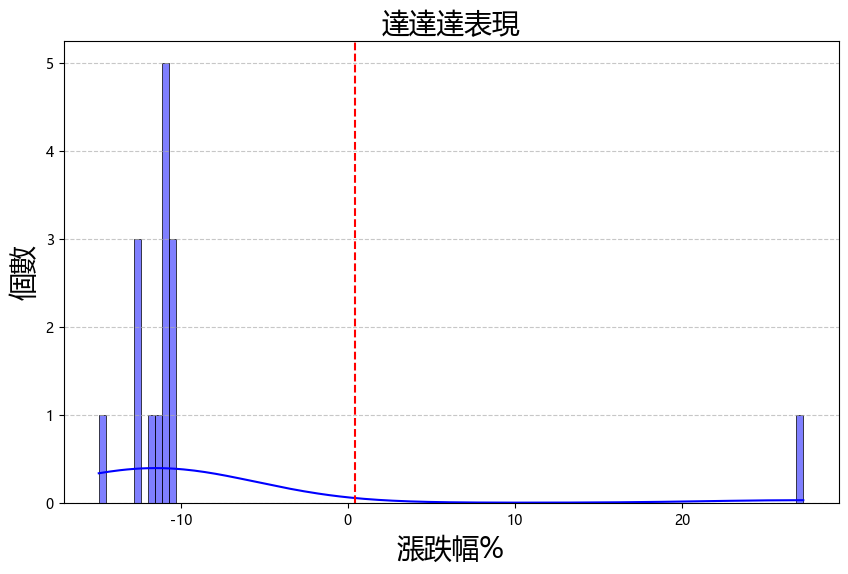

敗%
-11.542857142857144
勝%
27.25
平均%
-8.956666666666667
勝率
1
14
勝率
0.06666666666666667
賺賠比
2.360767326732673


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

# 計算每日百分比變動
daylist = earn_date_list['earn_close']

# 繪製直方圖
plt.figure(figsize=(10, 6))  # 設置圖形大小
sns.histplot(daylist, bins=100, kde=True, color='blue')  # 使用 Seaborn 繪製直方圖，加入 KDE 曲線
plt.title('達達達表現', fontsize=20)  # 標題
plt.xlabel('漲跌幅%', fontsize=20)  # x 軸標籤
plt.ylabel('個數', fontsize=20)  # y 軸標籤
# 在 x=0.435 的地方畫一條垂直線
plt.axvline(x=0.435, color='red', linestyle='--', label='Price = 0.435')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # 加入網格線
plt.show()

print('敗%')
print(daylist[daylist <= 0].mean())
print('勝%')
print(daylist[daylist > 0].mean())
print('平均%')
print(daylist.mean())

print('勝率')

loss = len(daylist[daylist <= 0])
win = len(daylist[daylist > 0])

print(win)
print( loss)
print('勝率')
print(win / (win + loss))
print('賺賠比')
print(-daylist[daylist > 0].mean() / daylist[daylist <= 0].mean())



In [161]:
today = datetime.now().date()
today.strftime('%Y-%m-%d')

'2024-08-26'